# Metadata

* Title: **Final Project Report**
* Class: DS 5100
* Date: July 15, 2022
* Student Name: Anneda Rong
* Student Net ID: aar2dk
* This URL: https://github.com/ontoligent/DS5100-2022-06-R/blob/main/final-project-info/FinalProjectSubmissionTemplate.ipynb
* GitHub Repo URL: https://github.com/annedarong/MonteCarlo

# The Monte Carlo Module

In [5]:
from multiprocessing.sharedctypes import Value
from operator import index
import pandas as pd
import numpy as np
import random

class Die:
    
    def __init__(self, faces):
        '''
        Initializes the Die class. Takes in an array of faces and initalizes all weights of the face to 1 and creates a dataframe with the array of faces and weights.

        @faces: An array or list of ints or strings of numbers
        '''
        self.faces = faces
        self.weight = np.full(len(faces),1.0)
        self._face_weight_df = pd.DataFrame({'Faces':self.faces,'Weights':self.weight})
    
    def change_weight(self, face, new_weight):
        '''
        Changes a face's corresponding weight. Accepts the face value that the new weight will be applied to.

        @face: An integer or string of the face to change
        @new_weight: The new weight value to change the corresponding face to
        '''
        current_faces = self._face_weight_df['Faces']
        is_face = (face == current_faces).any()
        if (not is_face):
            raise Exception("The 'face' passed is not found.")

        try:
            float(new_weight)
        except ValueError:
            raise ValueError("The 'weight' passed cannot be converted to a float/number. Please pass in a valid numerical value.")

        loc = current_faces[current_faces == face].index[0]
        self._face_weight_df.iloc[loc,1] = float(new_weight)
    
    def roll_die(self, num_times = 1):
        '''
        A function to roll the die based on the provided faces and weights. Will return a list of face outcome(s)

        @num_times: An integer representing the number of times to roll the die. Default is set to 1.
        '''
        faces = self._face_weight_df['Faces']
        weights = self._face_weight_df['Weights']
        outcome = random.choices(faces,weights,k = num_times)
        return(outcome)
    
    def show(self):
        '''
        returns the dataframe
        '''
        return(self._face_weight_df)

class Game:
    def __init__(self, die_objects):
        self.die_objects = die_objects
    
    def play(self, num_times):
        '''
        takes how many times want to roll dice

        rolls the dice

        saves N x M df (where N = rolls and M = dice)
        '''
        game_dict = {}
        for i, val in enumerate(self.die_objects):
            game_dict[i] = val.roll_die(num_times)
        self._game_df = pd.DataFrame(game_dict)
        self._game_df.index = self._game_df.index + 1
        self._game_df.index.name = "Rolls"
    
    def show(self, size = 'wide'):
        '''
        if wide, return game_df
        if narrow, set multi-index
        check if size is valid (either narrow or wide)
        '''
        game_df = self._game_df
        size = str.lower(size)
        if (size != 'wide' and size != 'narrow'):
            raise Exception("Invalid input. Input must either be 'narrow' or 'wide'.")
        if (size ==  'narrow'):
            values = self._game_df.values
            reshaped_val = np.reshape(values,values.shape[0] * values.shape[1])
            iterables = [[*range(1,len(self._game_df.index) + 1)], list(self._game_df.columns)]
            index = pd.MultiIndex.from_product(iterables, names = ["Roll","Dice"])
            game_df = pd.DataFrame({"Face Values": reshaped_val}, index = index)
        return game_df

class Analyzer:
    def __init__(self, game_object):
        '''
        Initializes the Game object along with the data type of the Game's values

        @game_object: A Game Object to be analyzed on
        '''
        self.game_object = game_object
        d_type = type(self.game_object.show().values)

    def jackpot(self):
        '''
        Finds the amount of time a play had all of the same faces on a roll.

        Returns the count of jackpots that were in the Game.
        Results of which play had the jackpot are returned in a dataframe called jackpot_df
        '''    
        same_row_df = self.game_object.show().apply(lambda x: x == x[0], axis = 1).all(1)
        self.jackpot_df = (self.game_object.show().iloc[:,0])[same_row_df]
        count = sum(same_row_df)
        return count

    def combo(self):
        '''
        Keeps track of distinct combinations. Results of the combination along with how many time the combinations appeared are returned in a dataframe called combo_df. All combonations are sorted in ascending order.
        '''
        game_df = self.game_object.show()
        combo_count = {}
        combo_list = []
        game_df.apply(lambda x: combo_list.append(tuple(x.sort_values())),axis = 1)
        for i in combo_list:
            if i in combo_count:
                combo_count[i] += 1
            else:
                combo_count[i] = 1
        index_name = [f"Position {x+1}"for x in range(game_df.shape[1])]
        self.combo_df = pd.DataFrame({"Combo Count":combo_count.values()}, index = pd.MultiIndex.from_tuples(combo_count.keys(), name = index_name))

    def face_counts_per_roll(self):
        '''
        Computes how many times a given face is rolled in each event.
        '''
        faces = self.game_object.die_objects[0].show()['Faces']
        current_game = self.game_object.show()
        faces_dict = dict.fromkeys(faces)
        values = current_game.values
        for i, val in enumerate(values):
            for v in val:
                value_dict = faces_dict[v]
                if (value_dict == None):
                    faces_dict[v] = [0 for x in range(current_game.shape[0])]
                faces_dict[v][i] += 1
        self.face_counts_df = pd.DataFrame(faces_dict)
        self.face_counts_df.index += 1
        self.face_counts_df.index.name = "Roll Number"
        self.face_counts_df.fillna(0,inplace=True)

# Test Module

In [14]:
import unittest

class TestDie(unittest.TestCase):
    test_die = Die(["H","T"])
    def test_change_weight_throws_exception_face(self):
        with self.assertRaises(Exception):
            self.test_die.change_weight("HT",1)
    

    def test_change_weight_throws_exception_weight(self):
        with self.assertRaises(ValueError):
            self.test_die.change_weight("H","Not real float")

class TestGame(unittest.TestCase):
    test_die = Die(["H","T"])
    test_game = Game([test_die])

    def test_play_normal(self):
        self.test_game.play(100)
        expected = 100
        actual = len(self.test_game.show())
        print(actual)
        self.assertEqual(expected,actual)

class TestAnalyzer(unittest.TestCase):
    test_die = Die(["H","T"])
    test_game = Game([test_die])
    test_game.play(100)
    test_analyzer = Analyzer(test_game)

    def test_same_jackpot_count(self):
        count = self.test_analyzer.jackpot()
        actual = len(self.test_analyzer.jackpot_df)
        self.assertEqual(count,actual)


# if __name__ == '__main__':
#     unittest.main()

unittest.main(argv=[''], verbosity=2, exit=False)


test_same_jackpot_count (__main__.TestAnalyzer) ... ok
test_change_weight_throws_exception_face (__main__.TestDie) ... ok
test_change_weight_throws_exception_weight (__main__.TestDie) ... ok
test_play_normal (__main__.TestGame) ... 

100


ok

----------------------------------------------------------------------
Ran 4 tests in 0.030s

OK


# Test Results

# A text block with the output of a successful test.

test_same_jackpot_count (__main__.TestAnalyzer) ... ok
test_change_weight_throws_exception_face (__main__.TestDie) ... ok
test_change_weight_throws_exception_weight (__main__.TestDie) ... ok
test_play_normal (__main__.TestGame) ...100
ok

----------------------------------------------------------------------
Ran 4 tests in 0.030s

OK
<unittest.main.TestProgram at 0x7f90204d44c0>

# Scenarios

Code blocks with your scenarios and their outputs. 

These should have appropriate import statements even though the code is now in the same notebook as the classes it calls. 

## Scenario 1

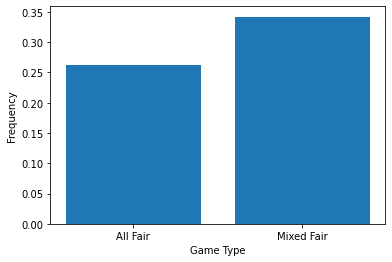

In [15]:
#from montecarlo import Die,Game,Analyzer
import pandas as pd
import matplotlib.pyplot as plt

faces = ["H","T"]
f_coin1 = Die(faces)
f_coin2 = Die(faces)
f_coin3 = Die(faces)     
all_fair = Game([f_coin1,f_coin2,f_coin3])
all_fair.play(1000)
all_fair_analyze = Analyzer(all_fair)
all_fair_jackpot = all_fair_analyze.jackpot()
all_fair_jackpot_freq = all_fair_jackpot/1000

uf_coin1 = Die(faces)
uf_coin1.change_weight("T",5)
uf_coin2 = Die(faces)
uf_coin2.change_weight("T",5)
mixed_fair = Game([f_coin1,uf_coin1,uf_coin2])
mixed_fair.play(1000)
mixed_fair_analyze = Analyzer(mixed_fair)
mixed_fair_jackpot = mixed_fair_analyze.jackpot()
mixed_fair_jackpot_freq = mixed_fair_jackpot/1000

x = ['All Fair','Mixed Fair']
plt.bar(x,[all_fair_jackpot_freq, mixed_fair_jackpot_freq])
plt.xlabel('Game Type')
plt.ylabel('Frequency')
plt.show()

## Scenario 2

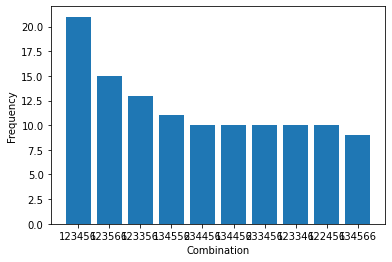

In [16]:
faces = [1,2,3,4,5,6]
all_fair_dice = []
for i in range(6):
    all_fair_dice.append(Die(faces))
dice_game1 = Game(all_fair_dice)
dice_game1.play(1000)
dice_game1_analyzer = Analyzer(dice_game1)
dice_game1_analyzer.combo()
dice_game1_combo = dice_game1_analyzer.combo_df
dice_game1_combo.sort_values(by= 'Combo Count',ascending=False,inplace=True)
combo_counts1 = [i[0] for i in (dice_game1_combo[:10]).values]
ten_freq_game1 = dice_game1_combo.index[:10].values

mixed_dice = []
for i in range(6):
    mixed_dice.append(Die(faces))
mixed_dice[1].change_weight(6,5)
mixed_dice[2].change_weight(6,5)
mixed_dice[3].change_weight(1,5)
dice_game2 = Game(mixed_dice)
dice_game2.play(1000)
dice_game2_analyzer = Analyzer(dice_game2)
dice_game2_analyzer.combo()
dice_game2_combo = dice_game2_analyzer.combo_df
dice_game2_combo.sort_values(by = 'Combo Count',ascending=False,inplace=True)
combo_counts2 = [i[0] for i in (dice_game2_combo[:10]).values]
ten_freq_game2 = dice_game2_combo[:10].index.values

ten_freq_game2 = [[str(x) for x in tup] for tup in ten_freq_game2]
ten_freq_game2 = [''.join(x) for x in ten_freq_game2]

ten_freq_game1 = [[str(x) for x in tup] for tup in ten_freq_game1]
ten_freq_game1 = [''.join(x) for x in ten_freq_game1]

plt.bar(ten_freq_game1,combo_counts1)
plt.xlabel('Combination')
plt.ylabel('Frequency')
plt.show()

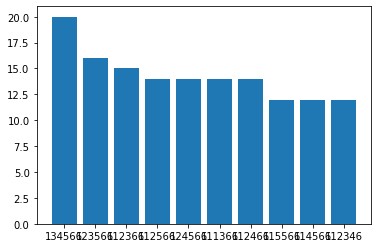

In [17]:
plt.bar(ten_freq_game2,combo_counts2)
plt.show()

## Scenario 3

In [20]:
letters_df = pd.read_csv('letter-freqs.csv', delimiter='\t',header=None)
letter_faces = letters_df[0]
letter_list = []
for i in range(5):
    letter_die = Die(letter_faces)
    letters_df.apply(lambda x: letter_die.change_weight(x[0],x[1]),axis = 1)
    letter_list.append(letter_die)
letter_game = Game(letter_list)
letter_game.play(1000)
letter_analyzer = Analyzer(letter_game)
letter_analyzer.combo()

In [21]:
pd.set_option('display.max_rows',100)
letter_analyzer.combo_df.head(100)

,,,,,Combo Count
Position 1,Position 2,Position 3,Position 4,Position 5,
I,L,N,R,U,1
E,L,O,U,Y,1
A,E,I,S,W,3
C,O,O,R,S,1
N,O,P,S,U,1
A,F,P,R,U,1
C,E,K,T,U,1
R,S,S,U,V,1
C,E,K,N,O,1


#### Question: How many combos can you that look like actual English words?

--- Previewing the first 100 rows, it looks like there are less than 10 combos that look like actual English words.

#### Question: Based on your eye count, what is the relative frequency of these words versus the rest?
--- A low frequency. 

# Directory Listing

A code block that executes the following bash command: 

```bash
!ls -lRF -o
```

In [2]:
!ls -lRF -o

total 320
-rw-r--r--@ 1 annedarong  76350 Jul 15 22:27 FinalProjectSubmissionTemplate.ipynb
-rw-r--r--  1 annedarong   1066 Jul 15 21:29 LICENSE
drwxr-xr-x  5 annedarong    160 Jul 15 21:16 MonteCarlo/
drwxr-xr-x  6 annedarong    192 Jul 15 22:27 MonteCarlo.egg-info/
-rw-r--r--  1 annedarong    534 Jul 15 22:14 README.md
drwxr-xr-x  3 annedarong     96 Jul 15 19:12 __pycache__/
-rw-r--r--@ 1 annedarong    234 Jul 15 13:34 letter-freqs.csv
-rw-r--r--  1 annedarong  63369 Jul 15 22:06 montecarlo_demo.ipynb
-rw-r--r--  1 annedarong   1106 Jul 15 22:16 montecarlo_tests.py
-rw-r--r--@ 1 annedarong    293 Jul 15 20:33 setup.py

./MonteCarlo:
total 24
-rw-r--r--  1 annedarong    40 Jul 15 20:34 __init__.py
-rw-r--r--  1 annedarong  5928 Jul 15 20:54 montecarlo.py

./MonteCarlo.egg-info:
total 32
-rw-r--r--  1 annedarong  240 Jul 15 22:27 PKG-INFO
-rw-r--r--  1 annedarong  202 Jul 15 22:27 SOURCES.txt
-rw-r--r--  1 annedarong    1 Jul 15 22:27 dependency_links.txt
-rw-r--r--  1 annedarong   11

# Installation Output Listing
    
A code block that executes the code to install your your package and outputs a successful installation.

In [1]:
# Installation commands
!pip install -e .

Obtaining file:///Users/annedarong/Desktop/DS5100_FinalProject
  Running setup.py develop for MonteCarlo
